## 6. 파이토치 : 날씨 이미지 분류 모델

### 데이터 세트 다운로드

In [1]:
%cd weather_dataset

/home/jupyter_home/pingu/fc-data-signature/part1/chapter4/weather_dataset


### 라이브러리 불러오기(Load Libraries)

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

### 데이터 세트 불러오기(Load Dataset)

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [4]:
train_dataset = datasets.ImageFolder(
    root='train/',
    transform=transform_train
)

dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(
    root='test/',
    transform=transform_test
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

### 데이터 시각화(Data Visualization)

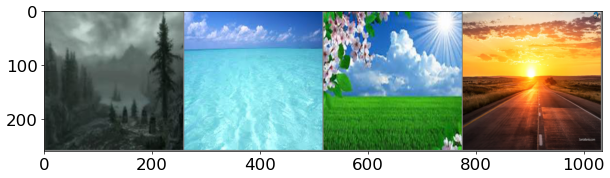

['Cloudy', 'Shine', 'Shine', 'Sunrise']


In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def imshow(input):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.show()

class_names = {
  0: "Cloudy",
  1: "Rain",
  2: "Shine",
  3: "Sunrise"
}

iterator = iter(train_dataloader)

imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)])

### 딥러닝 모델 학습(Training)

In [15]:
learning_rate = 0.01
log_step = 20

# model = models.resnet50(pretrained=True)
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [16]:
import time

def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [17]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_epochs}.pth')

[Epoch: 1 - Training]
train loss: 0.018168010711669923, accuracy: 0.5970370173454285
elapsed time: 10.545187950134277
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.01237320527434349, running val accuracy: 0.84375
val loss: 0.01389567139586048, accuracy: 0.8461538553237915
elapsed time: 1.5495922565460205
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.00582038523974242, accuracy: 0.9214814901351929
elapsed time: 10.103825330734253
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.0026633329689502716, running val accuracy: 0.984375
val loss: 0.0030577631568062236, accuracy: 0.976331353187561
elapsed time: 1.527977705001831
[Info] best validation accuracy!
[Epoch: 3 - Training]
train loss: 0.0019026357763343388, accuracy: 0.9674074053764343
elapsed time: 9.946769952774048
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.0017030235612764955, running val accuracy: 0.96875
val loss: 0.0022352781345152998, accuracy: 0.9644970297813416
elapsed time: 1.

### 학습 결과 확인하기

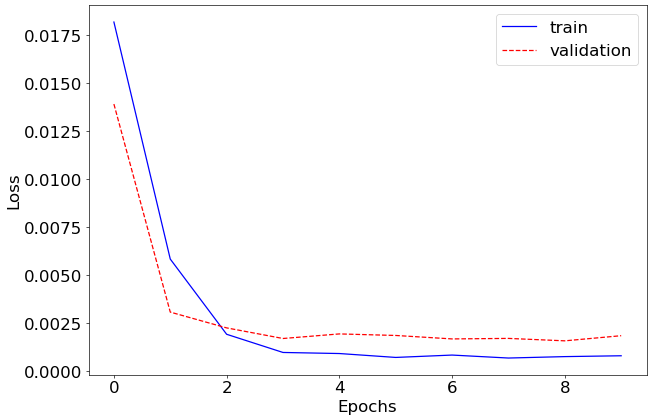

In [18]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

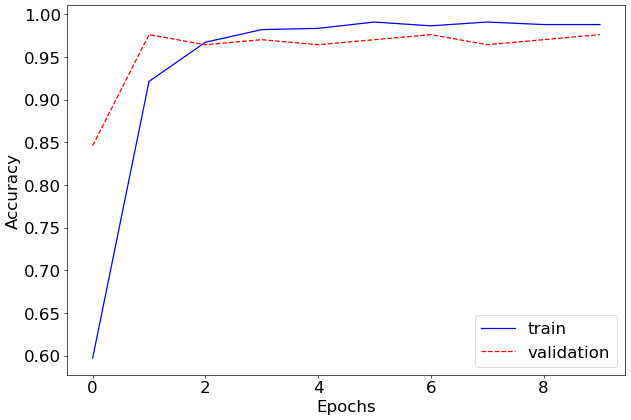

In [19]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [22]:
# model = models.resnet50(pretrained=True)
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model = model.cuda()
# ~/weather_dataset/best_checkpoint_epoch_*.pth
model_path = 'best_checkpoint_epoch_2.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.004265280440449715, running test accuracy: 0.9375
test loss: 0.002752778859431209, accuracy: 0.9608541131019592
elapsed time: 1.3319518566131592
Test loss: 0.00275278
Test accuracy: 96.09%
